In [3]:
from dgd.utils.utils5 import *
import pickle, time
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import re
from pathlib import Path
import pandas as pd
from typing import List, Dict
from tqdm.notebook import tqdm   
import numpy as np        

from dgd.environments.drl3env_loader4 import _apply_implicit_or, _compute_hash, _compute_truth_key

KeyboardInterrupt: 

In [3]:
def load_registry(pkl_file):
    """Load the pickle and rebuild NetworkX graphs."""
    with open(pkl_file, "rb") as f:
        saved = pickle.load(f)

    registry = {}
    for h, bucket in saved.items():
        restored = []
        for canon_nl, orig_nl, e in bucket:
            canon = nx.node_link_graph(canon_nl)
            orig  = nx.node_link_graph(orig_nl)
            restored.append((canon, orig, e))
        registry[h] = restored
    return registry

In [4]:
run_dir = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_0x0068/seed_1"

run_dir = Path(run_dir)

In [5]:
rx = re.compile(r"shared_registry_([\d_]+)\.pkl$")

def tag_value(p: Path) -> int:
    """Return the numeric tag, e.g. '4_800' -> 4800."""
    m = rx.fullmatch(p.name)
    if not m:
        raise ValueError(f"Not a registry file: {p}")
    return int(m.group(1).replace("_", ""))     # drop underscores, then int()

try:
    latest = max(
        (p for p in run_dir.glob("shared_registry_*.pkl")),
        key=tag_value
    )
    print("Latest snapshot:", latest, "steps =", tag_value(latest))
    pkl_path = latest
except ValueError:
    print("No shared_registry_*.pkl found in", run_dir)

Latest snapshot: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_0x0068/seed_1/shared_registry_51_200.pkl steps = 51200


Multiinput_testing_screening_smaller_designs_V2 approach


In [6]:
registry = load_registry(pkl_path)      # ← your pickle path

In [17]:
import random

# ────────────────────────────────────────────────────────────────
# USER-TUNABLE PARAMS
# ────────────────────────────────────────────────────────────────
SAMPLE_FRACTION = 0.01     # e.g. 0.10 → random 10 % of the registry
SAMPLE_SIZE     = None     # e.g. 500  → exactly 500 entries
RANDOM_SEED     = 42       # keep results reproducible
# set both SAMPLE_FRACTION and SAMPLE_SIZE to None to use the full registry
# ────────────────────────────────────────────────────────────────

random.seed(RANDOM_SEED)

# 1) flatten the registry  …  (canon, orig, e, h)
flat_triplets = [(canon, orig, e, h)
                 for h, bucket in registry.items()
                 for canon, orig, e in bucket]

# 2) optional down-sampling
if SAMPLE_SIZE is not None:
    flat_triplets = random.sample(flat_triplets, k=min(SAMPLE_SIZE,
                                                       len(flat_triplets)))
elif SAMPLE_FRACTION is not None:
    k = int(len(flat_triplets) * SAMPLE_FRACTION)
    flat_triplets = random.sample(flat_triplets, k=max(1, k))

print(f"Using {len(flat_triplets)} / {sum(len(b) for b in registry.values())} "
      "registry entries")

# 3) feed originals into your unchanged loop
candidate_graphs_original = [orig for _, orig, _, _ in flat_triplets]

Using 254 / 25495 registry entries


In [18]:

energy_evaluations = []          # your loop will fill this list

for g_candidate in tqdm(candidate_graphs_original, desc="Evaluating Implicit OR"):
#for g_candidate in candidate_graphs_original:    

    # Identify output node (assuming 1)
    exit_nodes = [n for n in g_candidate.nodes() if g_candidate.out_degree(n) == 0]
    if not exit_nodes:
        energy_evaluations.append((g_candidate, g_candidate, float("inf")))
        continue

    output_node = exit_nodes[0]
    size_input_to_OR_gate = 2

    # Check potential implicit OR
    implicit_OR_results = check_implicit_OR_existence_v2(
        g_candidate, output_node, size_input_to_OR_gate
    )

    max_removal = 0
    max_implicit_OR_key = None

    for key, value in implicit_OR_results.items():
        if (value['is_there_an_implicit_OR'] and value['number_of_nodes_available_for_removal'] > max_removal):
            max_removal = value['number_of_nodes_available_for_removal']
            max_implicit_OR_key = key

    # Temporarily rewrite (for energy measurement only)
    if max_implicit_OR_key is not None:
        cut  = implicit_OR_results[max_implicit_OR_key]['cut']
        cone = implicit_OR_results[max_implicit_OR_key]['cone']
        g_rewritten = add_implicit_OR_to_dag_v2(g_candidate, output_node, cut, cone)
        # example energy measure: number_of_nodes() minus 4 input + 1 output
        energy_value = len(g_rewritten.nodes()) - 4 - 1
    else:
        energy_value = len(g_candidate.nodes()) - 4 - 1
        g_rewritten = g_candidate
    # Store (original graph, energy_of_temporary_rewritten)
    
    energy_evaluations.append((g_rewritten, g_candidate, energy_value))

    
mismatches = []

for (canon_reg, _orig, e_reg, h), (g_rewritten, _orig_again, e_new) in zip(flat_triplets, energy_evaluations):

    iso_ok    = nx.is_isomorphic(canon_reg, g_rewritten)
    energy_ok = (e_new == e_reg)

    if not (iso_ok and energy_ok):
        print("Mismatch")
        mismatches.append((h, iso_ok, e_reg, e_new))

# ────────────────────────────────────────────────────────────────────
# 4)  report
# ────────────────────────────────────────────────────────────────────
if mismatches:
    total = len(flat_triplets)
    bad   = len(mismatches)
    print(f"✗ {bad} of {total} entries differ:")
    for h, iso_ok, e_ref, e_obs in mismatches[:10]:   # show first few
        print(f"  hash={h}  iso_match={iso_ok}  registry_e={e_ref}  loop_e={e_obs}")
else:
    print(f"✓ All {len(flat_triplets)} graphs match canonical form and energy.") 


Evaluating Implicit OR: 100%|██████████| 254/254 [00:47<00:00,  5.36it/s]


✓ All 254 graphs match canonical form and energy.


drl3env_loader4.py approach

In [19]:

energy_evaluations2 = []            # your loop will append triples here
# ─────────────────────────  UNCHANGED USER LOOP  ───────────────────────────────
for g_candidate in tqdm(candidate_graphs_original,
                        desc="Evaluating Implicit OR"):
    g_canon = _apply_implicit_or(g_candidate)            # returns canonical
    energy_value2, info = energy_score(
        g_candidate, check_implicit_OR_existence_v3
    )
    energy_evaluations2.append((g_canon, g_candidate, energy_value2))
# ───────────────────────────────────────────────────────────────────────────────

# 4) validation
mismatches = []

for (canon_reg, _orig, e_reg, h), \
    (g_canon, _g_after_or, e_new) in zip(flat_triplets, energy_evaluations2):

    iso_ok    = nx.is_isomorphic(g_canon, canon_reg)
    energy_ok = (e_new == e_reg)

    if not (iso_ok and energy_ok):
        mismatches.append((h, iso_ok, e_reg, e_new))

# 5) report
if mismatches:
    total = len(flat_triplets)
    bad   = len(mismatches)
    print(f"✗ {bad} of {total} entries differ:")
    for h, iso_ok, e_ref, e_obs in mismatches[:10]:   # show first few mismatches
        print(f"  hash={h}  iso_match={iso_ok}  registry_e={e_ref} "
              f"loop_e={e_obs}")
else:
    print(f"✓ All {len(flat_triplets)} graphs match canonical form and energy.")


Evaluating Implicit OR:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating Implicit OR: 100%|██████████| 254/254 [00:00<00:00, 494.87it/s]


✓ All 254 graphs match canonical form and energy.


In [20]:
# ------------------------------------------------------------------
# 6)  Compare energy_evaluations  vs  energy_evaluations2
#     Each entry is:
#       energy_evaluations : (g_rewritten , g_orig , energy_int)
#       energy_evaluations2: (g_canon     , g_orig , energy_int)
# ------------------------------------------------------------------
iso_mismatches     = []   # canonical graphs differ
energy_mismatches  = []   # numeric energy differs
length_mismatches  = (len(energy_evaluations) != len(energy_evaluations2))

if length_mismatches:
    print(f"List lengths differ: "
          f"{len(energy_evaluations)} vs {len(energy_evaluations2)}")

for idx, ((g_can1, _orig1, e1),
          (g_can2, _orig2, e2)) in enumerate(zip(energy_evaluations,
                                                 energy_evaluations2)):

    # 1) canonical graph equality (isomorphism)
    if not nx.is_isomorphic(g_can1, g_can2):
        iso_mismatches.append(idx)

    # 2) energy equality
    if e1 != e2:
        energy_mismatches.append((idx, e1, e2))

# ------------------------------------------------------------------
# 7)  Report
# ------------------------------------------------------------------
total = min(len(energy_evaluations), len(energy_evaluations2))

if not iso_mismatches and not energy_mismatches and not length_mismatches:
    print(f"✓ All {total} entries match in canonical form *and* energy.")
else:
    print(f"✗ Detected discrepancies among {total} paired entries:")

    if iso_mismatches:
        print(f"  • Canonical graph mismatch count: {len(iso_mismatches)}")
        print("    first few indices:", iso_mismatches[:10])

    if energy_mismatches:
        print(f"  • Energy mismatch count: {len(energy_mismatches)}")
        for idx, old_e, new_e in energy_mismatches[:10]:
            print(f"    idx {idx}: energy1={old_e}  energy2={new_e}")


✓ All 254 entries match in canonical form *and* energy.


Testing motif caninical (functions from shared registry ploting and analysis)

In [1]:
import pickle, time
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import re
from pathlib import Path
import pandas as pd
from typing import List, Dict
from tqdm.notebook import tqdm   
import numpy as np        

from dgd.environments.drl3env_loader4 import _apply_implicit_or, _compute_hash, _compute_truth_key

from dgd.utils.utils5 import (
    calculate_truth_table_v2,
    generate_one_hot_features_from_adj,
    resize_matrix,
    energy_score,
    check_implicit_OR_existence_v3,
    add_implicit_OR_to_dag_v2,
    exhaustive_cut_enumeration_dag,
    is_fanout_free_standalone,
    generate_subgraph,
    simulate_signal_propagation_binary,
    plot_circuit_layered,
    write_tt_files,
)

from dgd.utils.verification import *

Done loading action motifs. There are 15928 unique motifs.


In [2]:
MOTIFS_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/action_motifs.pkl"
with open(MOTIFS_PATH, "rb") as f:
    action_motifs = pickle.load(f)

UNIQUE_GRAPHS = action_motifs["graphs"]       
TTABLE_TO_ACTIONS = action_motifs["lookup"]

In [3]:
def build_motif_canonicals():
    """
    Compute canonical form for every motif in global UNIQUE_GRAPHS and
    store them in UNIQUE_GRAPHS_canonical, with a progress bar.
    """
    global UNIQUE_GRAPHS_canonical
    bar = tqdm(UNIQUE_GRAPHS, desc="Canonicalising motifs", unit="motif")
    UNIQUE_GRAPHS_canonical = [_apply_implicit_or(g.copy()) for g in bar]
    print(f"Built canonical bank for {len(UNIQUE_GRAPHS_canonical)} motifs.")

In [4]:
build_motif_canonicals()

Canonicalising motifs:   0%|          | 0/15928 [00:00<?, ?motif/s]

Built canonical bank for 15928 motifs.


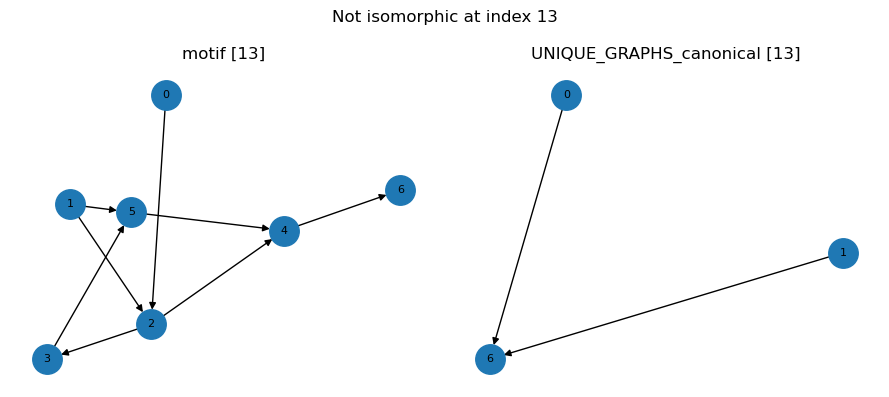

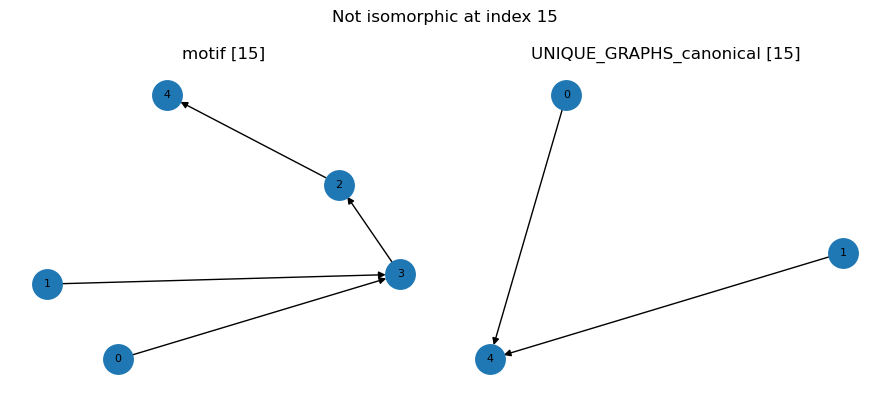

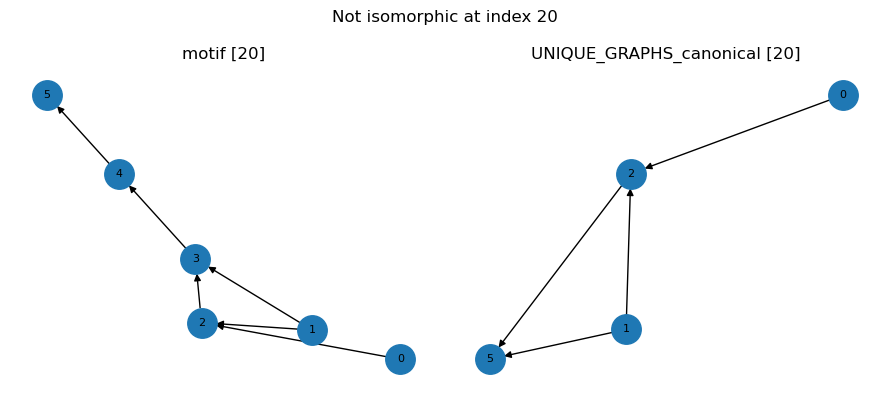

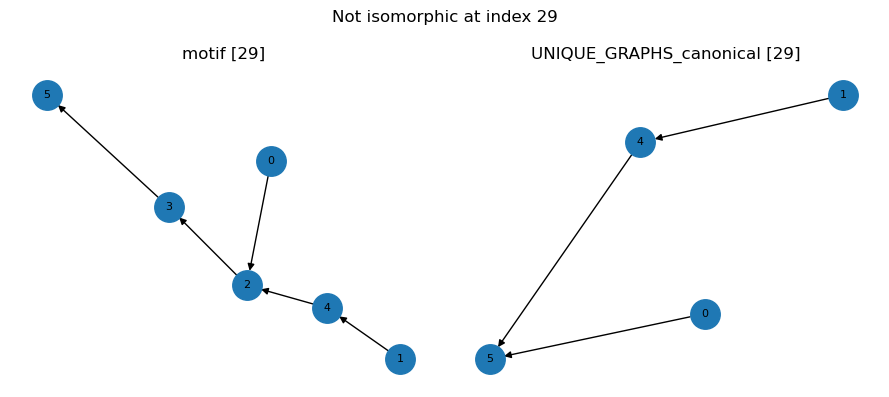

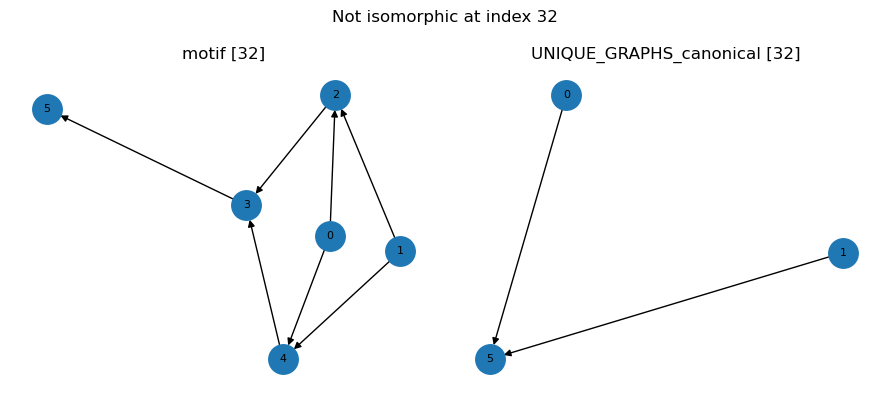

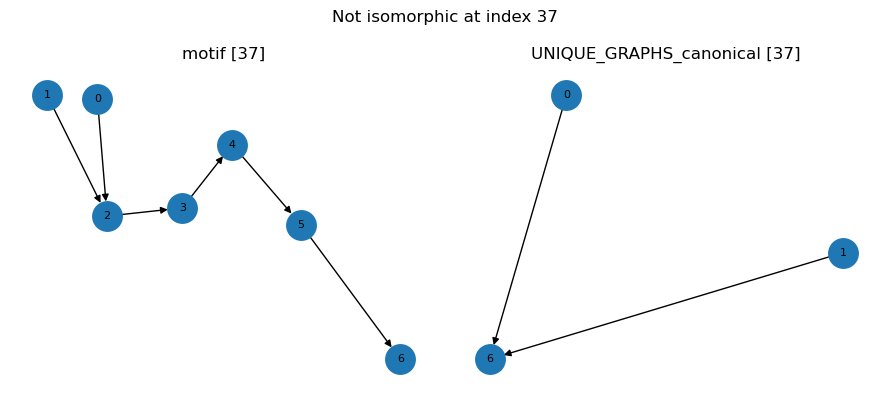

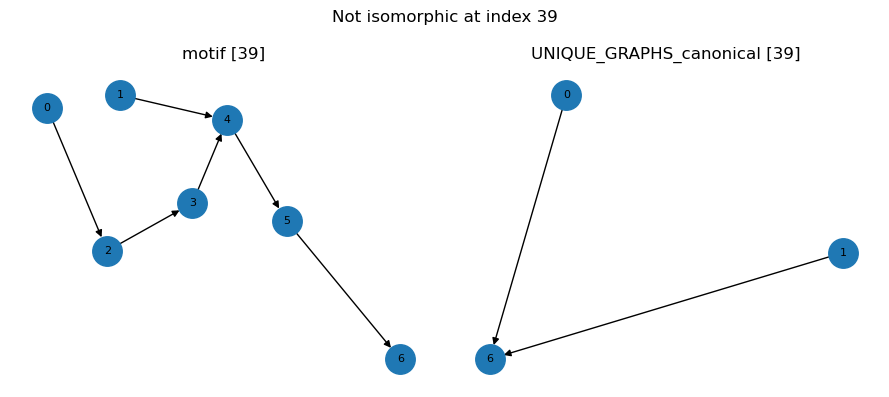

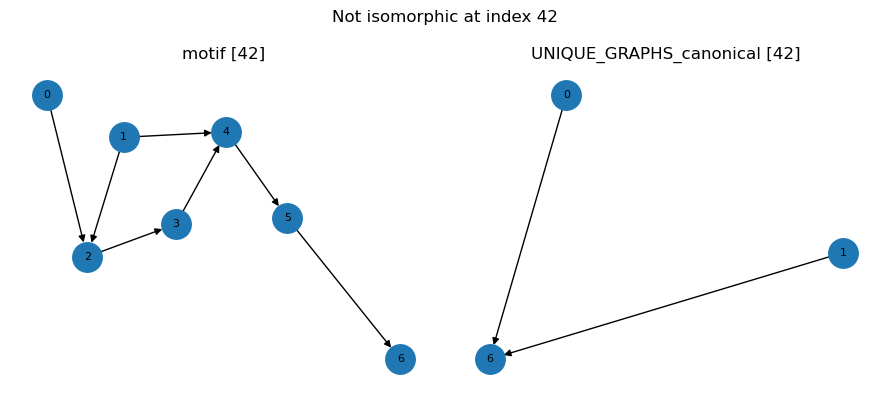

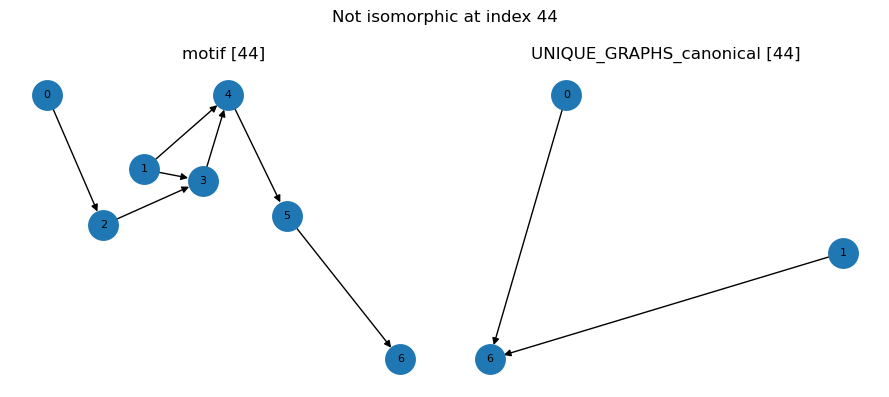

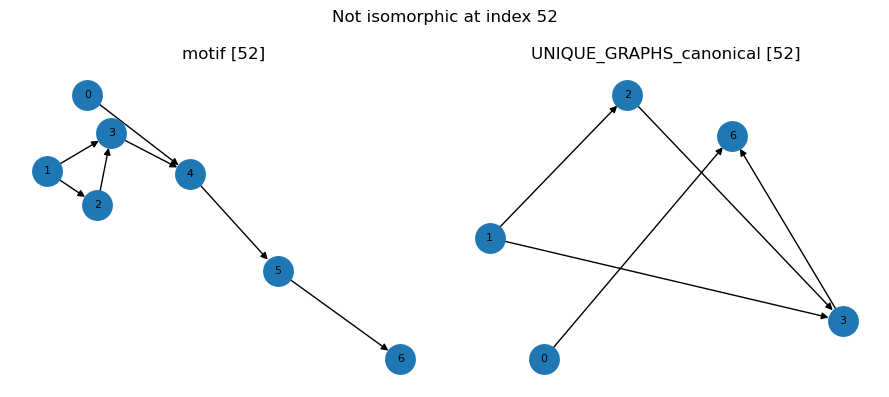

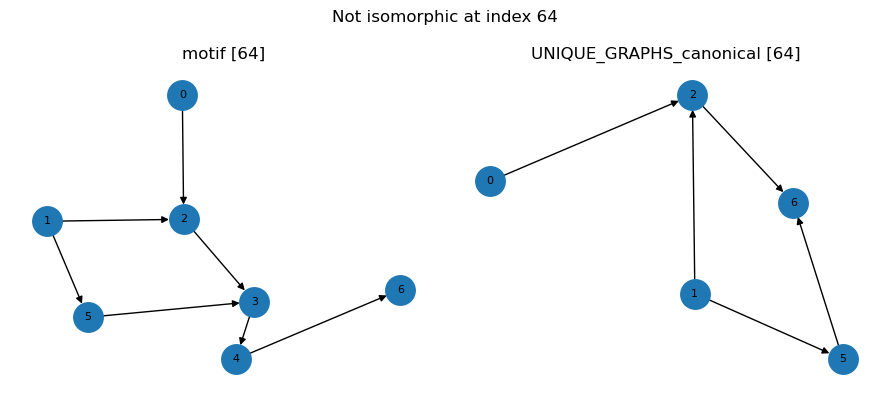

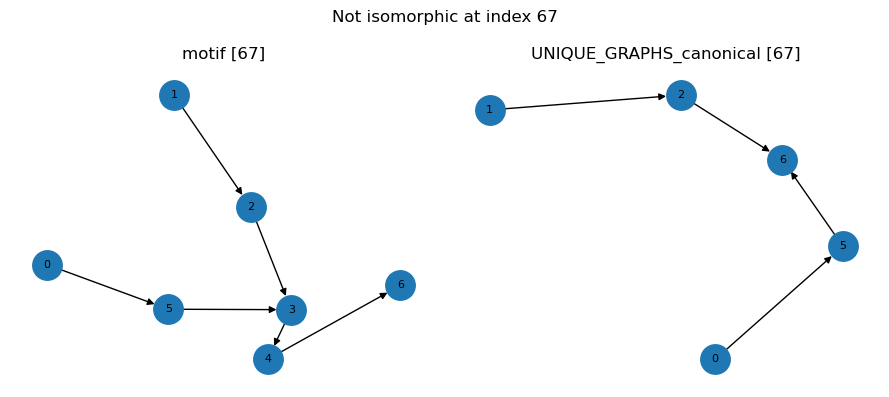

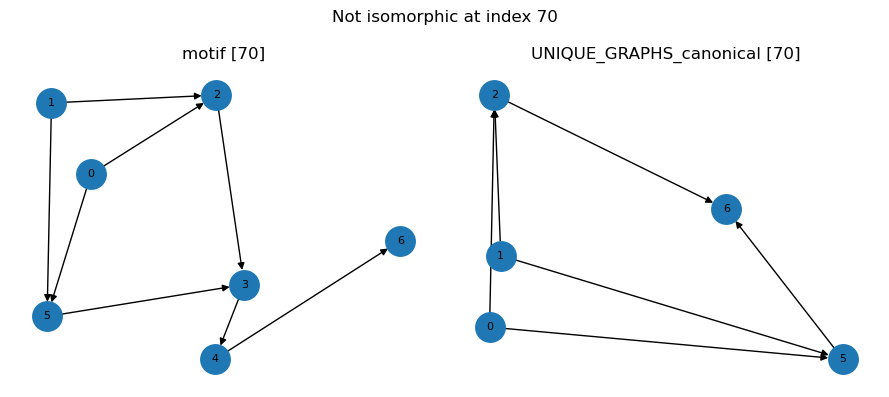

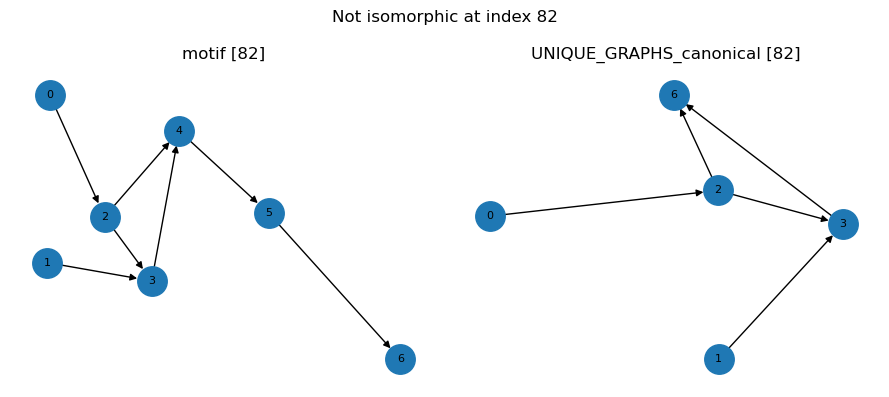

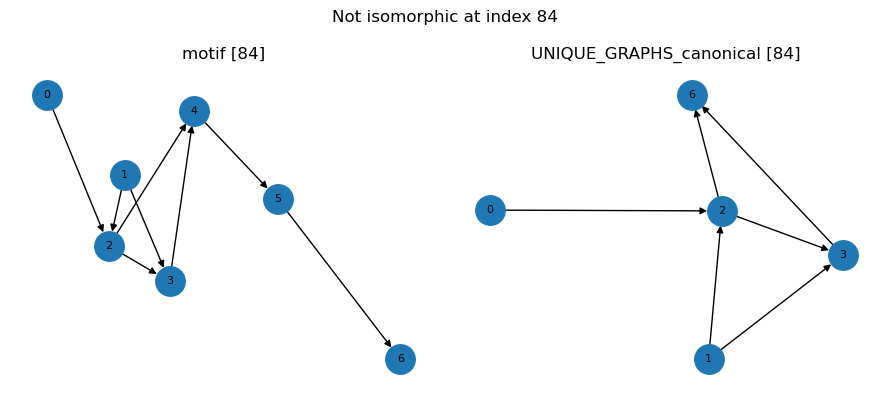

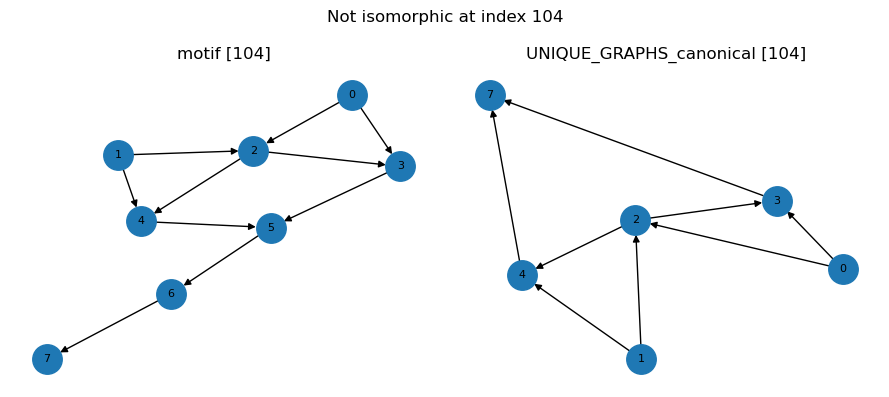

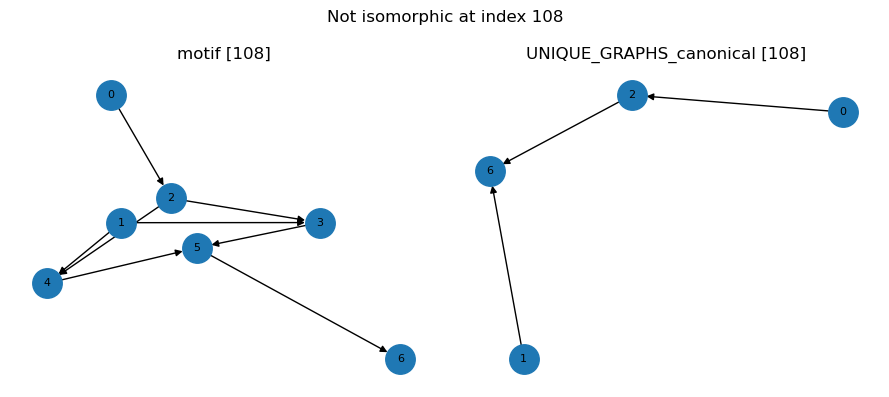

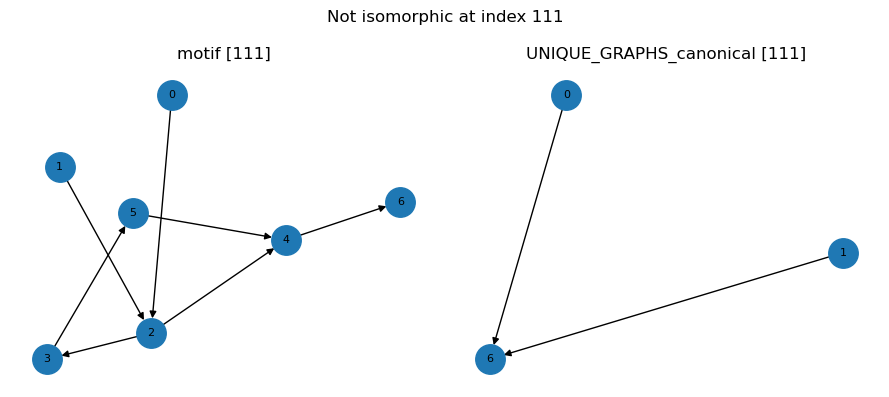

In [13]:
for index, motif in enumerate(UNIQUE_GRAPHS):
    
    canon = UNIQUE_GRAPHS_canonical[index]
    
    input_nodes  = [node for node in motif.nodes() if motif.in_degree(node) == 0]
    
    if len(input_nodes) == 2:
    
        if not nx.is_isomorphic(motif, canon):
            fig, axes = plt.subplots(1, 2, figsize=(9, 4))

            # Layouts (fixed seed so comparisons are easier to eyeball)
            pos1 = nx.spring_layout(motif, seed=42)
            pos2 = nx.spring_layout(canon, seed=42)

            nx.draw_networkx(motif, pos=pos1, ax=axes[0],
                            with_labels=True, node_size=450, font_size=8)
            axes[0].set_title(f"motif [{index}]")
            axes[0].axis("off")

            nx.draw_networkx(canon, pos=pos2, ax=axes[1],
                            with_labels=True, node_size=450, font_size=8)
            axes[1].set_title(f"UNIQUE_GRAPHS_canonical [{index}]")
            axes[1].axis("off")

            plt.suptitle(f"Not isomorphic at index {index}")
            plt.tight_layout()
            plt.show()

Determine OR structires in motifs

In [5]:
TTABLE_TO_ACTIONS[(2, 7)]

[13, 15, 32, 37, 39, 42, 44, 111]

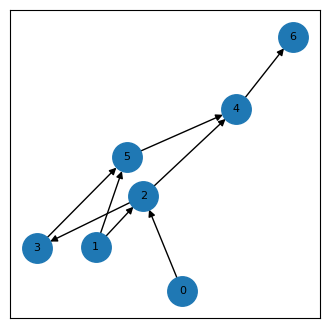

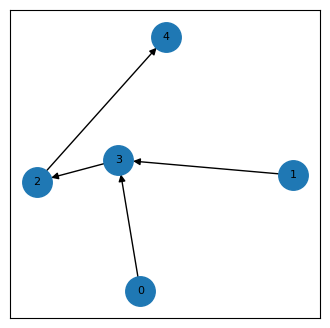

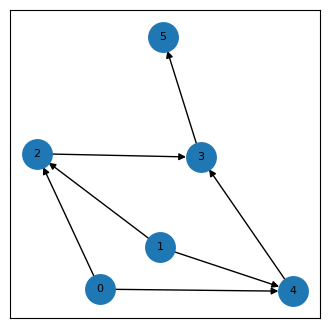

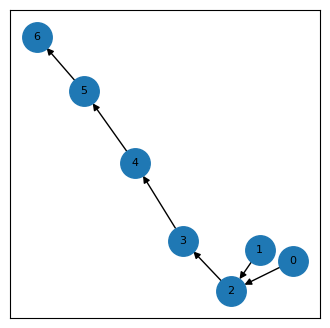

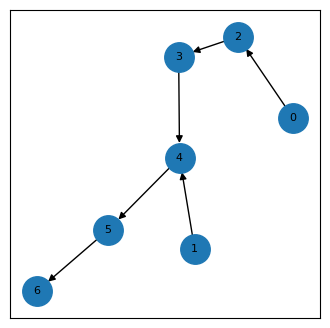

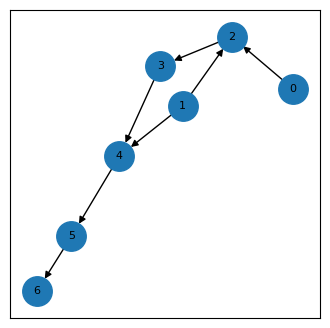

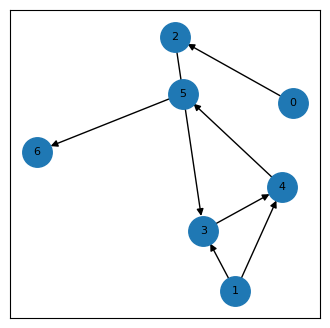

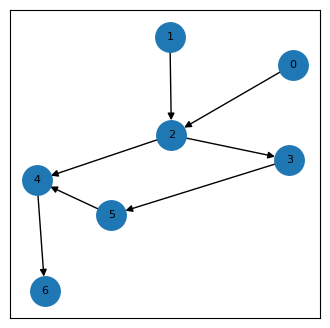

In [10]:
for index in [13, 15, 32, 37, 39, 42, 44, 111]:
    or_graph = UNIQUE_GRAPHS[index]
    plt.figure(figsize=(4, 4)) 
    nx.draw_networkx(or_graph, with_labels=True, node_size=450, font_size=8)